# Chapter 9 — Training, Monitoring & Evaluation

In [12]:
# ── Colab auto-setup (safe to run locally too) ───────────────────
import sys, os

if "google.colab" in sys.modules:
    if not os.path.exists("/content/vietnamese-tts-course"):
        !git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git /content/vietnamese-tts-course
    os.chdir("/content/vietnamese-tts-course/chapters")
    !pip install -q librosa soundfile matplotlib

    if not os.path.exists("/content/VieNeu-TTS"):
        !git clone https://github.com/pnnbao97/VieNeu-TTS.git /content/VieNeu-TTS
        !pip install -q -e /content/VieNeu-TTS
    sys.path.insert(0, "/content/VieNeu-TTS")
    print("Colab setup complete.")

Colab setup complete.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import os

## 1. The Training Loss — What Are We Optimizing?

For TTS, we compute cross-entropy **only on speech token positions** (text positions are masked with `-100`):

$$\mathcal{L} = -\frac{1}{|S|} \sum_{t \in S} \log P(s_t \mid s_{<t},\ \text{context})$$

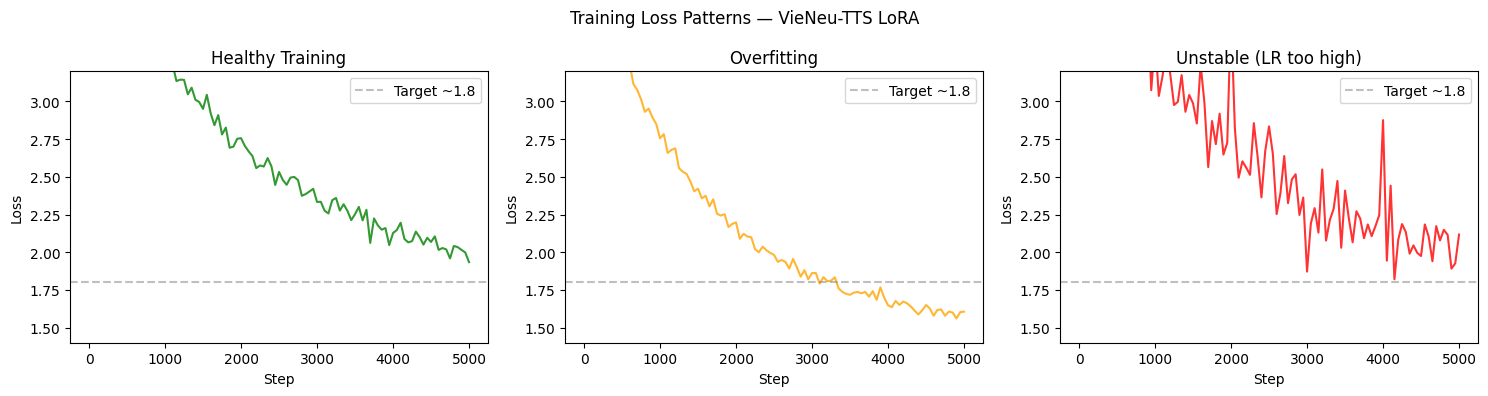

In [14]:
steps = np.arange(0, 5001, 50)
np.random.seed(42)

healthy = 2.5 * np.exp(-steps / 2000) + 1.8 + np.random.randn(len(steps)) * 0.05
overfit = 2.5 * np.exp(-steps / 1500) + 1.5 + np.random.randn(len(steps)) * 0.03
unstable = 2.5 * np.exp(-steps / 2000) + 1.8 + np.random.randn(len(steps)) * 0.15
unstable[40] += 0.8; unstable[80] += 0.5

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, loss, title, color in zip(axes,
    [healthy, overfit, unstable],
    ["Healthy Training", "Overfitting", "Unstable (LR too high)"],
    ["green", "orange", "red"]):
    ax.plot(steps, loss, color=color, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")
    ax.set_ylim(1.4, 3.2)
    ax.axhline(y=1.8, color='gray', linestyle='--', alpha=0.5, label='Target ~1.8')
    ax.legend()
plt.suptitle("Training Loss Patterns — VieNeu-TTS LoRA")
plt.tight_layout()
plt.show()

## 2. CER — Character Error Rate

In [15]:
def edit_distance(ref, hyp):
    m, n = len(ref), len(hyp)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1): dp[i][0] = i
    for j in range(n+1): dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            dp[i][j] = dp[i-1][j-1] if ref[i-1]==hyp[j-1] else 1+min(dp[i-1][j],dp[i][j-1],dp[i-1][j-1])
    return dp[m][n]

def cer(reference, hypothesis):
    ref = list(reference.replace(" ", ""))
    hyp = list(hypothesis.replace(" ", ""))
    return edit_distance(ref, hyp) / len(ref) * 100

examples = [
    ("Xin ch\u00e0o Vi\u1ec7t Nam.", "Xin ch\u00e0o Vi\u1ec7t Nam."),
    ("H\u00f4m nay tr\u1eddi \u0111\u1eb9p.", "H\u00f4m nay tr\u1eddi \u0111\u1eb9p"),
    ("T\u00f4i l\u00e0 VieNeu TTS.", "T\u00f4i l\u00e0 VieNeu TDS."),
    ("Machine learning th\u00fa v\u1ecb.", "Machine learning th\u00fa v\u1ecb."),
    ("N\u0103m nay th\u1eddi ti\u1ebft l\u1ea1nh.", "N\u0103m nay th\u1eddi ti\u1ebft lanh."),
]
print(f"{'Reference':<35} {'Hypothesis':<35} CER")
print("-"*80)
for ref, hyp in examples:
    score = cer(ref, hyp)
    print(f"{ref:<35} {hyp:<35} {score:.1f}%")

Reference                           Hypothesis                          CER
--------------------------------------------------------------------------------
Xin chào Việt Nam.                  Xin chào Việt Nam.                  0.0%
Hôm nay trời đẹp.                   Hôm nay trời đẹp                    7.1%
Tôi là VieNeu TTS.                  Tôi là VieNeu TDS.                  6.7%
Machine learning thú vị.            Machine learning thú vị.            0.0%
Năm nay thời tiết lạnh.             Năm nay thời tiết lanh.             5.3%


## 3. MCD — Mel Cepstral Distortion

$$\text{MCD} = \frac{10\sqrt{2}}{\ln 10} \cdot \frac{1}{T} \sum_{t=1}^{T} \sqrt{\sum_{d=1}^{D} (mc_d^{(t)} - \hat{mc}_d^{(t)})^2}$$

In [16]:
import sys
sys.path.insert(0, "..")
from vieneu import Vieneu

tts = Vieneu()
test_text = "H\u1ec7 th\u1ed1ng t\u1ed5ng h\u1ee3p ti\u1ebfng Vi\u1ec7t ho\u1ea1t \u0111\u1ed9ng t\u1ed1t."
mfcc_data = {}

for voice_id in ["Binh", "Tuyen", "Ly"]:
    voice = tts.get_preset_voice(voice_id)
    audio = tts.infer(test_text, voice=voice)
    mfcc = librosa.feature.mfcc(y=audio, sr=24000, n_mfcc=13)
    mfcc_data[voice_id] = mfcc
    print(f"Voice {voice_id}: {len(audio)/24000:.2f}s, MFCC shape: {mfcc.shape}")

tts.close()

# MCD between voices
voices = list(mfcc_data.keys())
for i in range(len(voices)):
    for j in range(i+1, len(voices)):
        v1, v2 = voices[i], voices[j]
        m1, m2 = mfcc_data[v1], mfcc_data[v2]
        min_t = min(m1.shape[1], m2.shape[1])
        diff = m1[1:, :min_t] - m2[1:, :min_t]
        mcd = (10 * np.sqrt(2) / np.log(10)) * np.mean(np.sqrt(np.sum(diff**2, axis=0)))
        print(f"MCD({v1} vs {v2}): {mcd:.2f} dB")

Loading backbone from: pnnbao-ump/VieNeu-TTS-0.3B-q4-gguf on cpu ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
llama_context: n_ctx_per_seq (2048) < n_ctx_train (4096) -- the full capacity of the model will not be utilized
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:186: UserWarning: The `resume_download` argument is deprecated and ignored in `hf_hub_download`. Downloads always resume whenever possible.
  warnings.warn(


Loading codec from: neuphonic/distill-neucodec on cpu ...


Loading weights:   0%|          | 0/49 [00:00<?, ?it/s]

   📢 Loaded 6 voices from voices.json
Voice Binh: 2.20s, MFCC shape: (13, 104)
Voice Tuyen: 2.82s, MFCC shape: (13, 133)
Voice Ly: 2.90s, MFCC shape: (13, 136)
MCD(Binh vs Tuyen): 806.36 dB
MCD(Binh vs Ly): 805.54 dB
MCD(Tuyen vs Ly): 633.50 dB


## 4. Checkpoint Selection Strategy

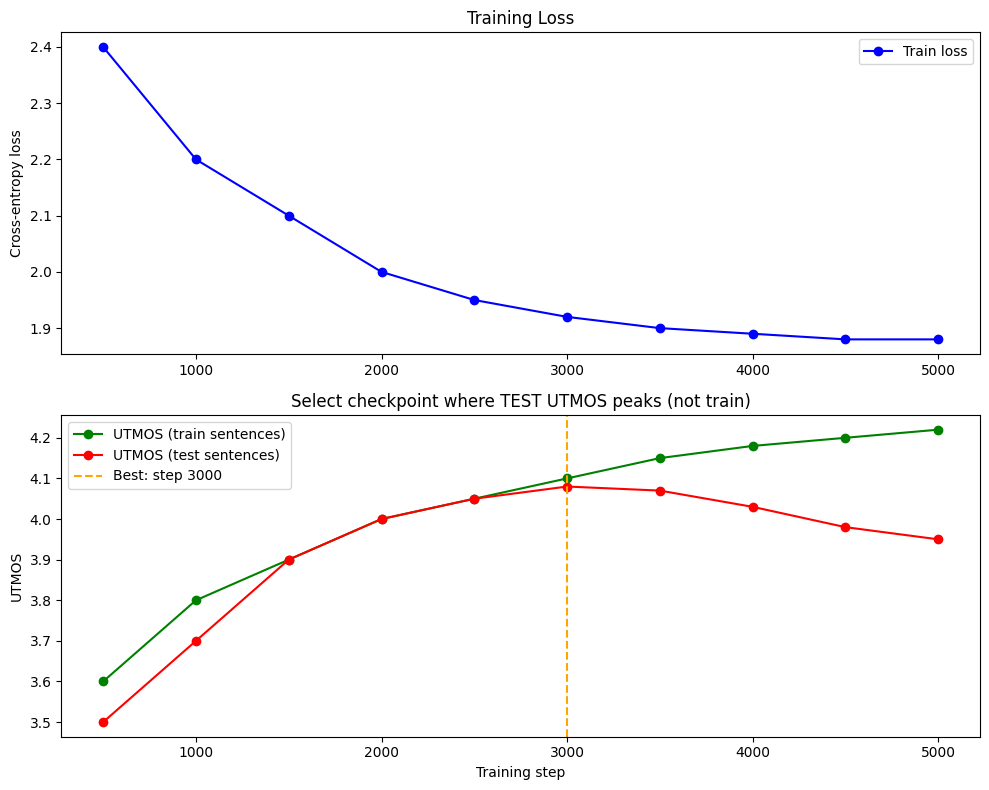

Best checkpoint: step 3000 (UTMOS test = 4.08)


In [17]:
checkpoints = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
train_loss   = [2.40, 2.20, 2.10, 2.00, 1.95, 1.92, 1.90, 1.89, 1.88, 1.88]
utmos_train  = [3.60, 3.80, 3.90, 4.00, 4.05, 4.10, 4.15, 4.18, 4.20, 4.22]
utmos_test   = [3.50, 3.70, 3.90, 4.00, 4.05, 4.08, 4.07, 4.03, 3.98, 3.95]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(checkpoints, train_loss, 'b-o', label="Train loss")
ax1.set_ylabel("Cross-entropy loss"); ax1.legend(); ax1.set_title("Training Loss")

ax2.plot(checkpoints, utmos_train, 'g-o', label="UTMOS (train sentences)")
ax2.plot(checkpoints, utmos_test,  'r-o', label="UTMOS (test sentences)")
best_idx = np.argmax(utmos_test)
best_step = checkpoints[best_idx]
ax2.axvline(x=best_step, color='orange', linestyle='--', label=f"Best: step {best_step}")
ax2.set_xlabel("Training step"); ax2.set_ylabel("UTMOS"); ax2.legend()
ax2.set_title("Select checkpoint where TEST UTMOS peaks (not train)")
plt.tight_layout(); plt.show()
print(f"Best checkpoint: step {best_step} (UTMOS test = {utmos_test[best_idx]:.2f})")

## 5. Vietnamese Tone Test Suite

In [18]:
from vieneu import Vieneu
from IPython.display import Audio, display

tts = Vieneu()
voice = tts.get_preset_voice("Binh")

tone_tests = [
    ("ma",  "ngang \u2014 flat level"),
    ("m\u00e0",  "huyen \u2014 falling"),
    ("m\u00e1",  "sac \u2014 rising"),
    ("m\u1ea3",  "hoi \u2014 dipping-rising"),
    ("m\u00e3",  "nga \u2014 creaky rising"),
    ("m\u1ea1",  "nang \u2014 heavy falling"),
]

for syllable, description in tone_tests:
    text = f"\u00c2m ti\u1ebft {syllable} mang thanh {description.split('\u2014')[0].strip()}."
    audio = tts.infer(text, voice=voice)
    print(f"{syllable} ({description}): {len(audio)/24000:.2f}s")
    display(Audio(audio, rate=24000))

tts.close()

Loading backbone from: pnnbao-ump/VieNeu-TTS-0.3B-q4-gguf on cpu ...


llama_context: n_ctx_per_seq (2048) < n_ctx_train (4096) -- the full capacity of the model will not be utilized


Loading codec from: neuphonic/distill-neucodec on cpu ...


Loading weights:   0%|          | 0/49 [00:00<?, ?it/s]

   📢 Loaded 6 voices from voices.json
ma (ngang — flat level): 1.80s


mà (huyen — falling): 1.72s


má (sac — rising): 2.02s


mả (hoi — dipping-rising): 1.74s


mã (nga — creaky rising): 2.02s


mạ (nang — heavy falling): 1.80s


## 6. Evaluation Summary

| Metric | Type | How to Compute | Target |
|--------|------|----------------|--------|
| CER | Objective | ASR → edit distance | < 5% |
| WER | Objective | ASR → word edit distance | < 10% |
| MCD | Objective | MFCC distance ref vs gen | < 8 dB |
| UTMOS | Semi-objective | Neural MOS predictor | > 3.8 |
| MOS | Subjective | Human rating 1–5 | > 4.0 |
| AB Test | Subjective | Which sounds better? | > 60% prefer |